# 1P - Cluster Features

In [1]:
from os import path

import numpy as np
import h5py
from tqdm import tqdm

%matplotlib inline
from rnn_tauid.common.mpl_setup import mpl_setup
import matplotlib.pyplot as plt
mpl_setup()

Input files and datasets:

In [2]:
# Sample paths
sig_jet_fname = "/lustre/user/cdeutsch/rnn-samples-v4/sig1P_jet.h5"
bkg_jet_fname = "/lustre/user/cdeutsch/rnn-samples-v4/bkg1P_jet_shuffle.h5"
sig_cluster_fname = "/lustre/user/cdeutsch/rnn-samples-v4/sig1P_cluster.h5"
bkg_cluster_fname = "/lustre/user/cdeutsch/rnn-samples-v4/bkg1P_cluster_shuffle.h5"

# Output sample
outf_fname = "/lustre/user/cdeutsch/rnn-feature-samples-v5/cluster/cluster_features_1p.h5"

# Plot output prefix
plot_prefix = "/lustre/user/cdeutsch/rnn-feature-samples-v5/cluster/cluster_features_1p_plots/"

In [3]:
# Tau-level datasets
sigf_jet = h5py.File(sig_jet_fname, "r")
bkgf_jet = h5py.File(bkg_jet_fname, "r")
sig_jet = sigf_jet["jet"]
bkg_jet = bkgf_jet["jet"]

# Cluster-level datasets
sigf_cluster = h5py.File(sig_cluster_fname, "r")
bkgf_cluster = h5py.File(bkg_cluster_fname, "r")
sig_cluster = sigf_cluster["cluster"]
bkg_cluster = bkgf_cluster["cluster"]

Sample fractions for training/validation

In [4]:
# Fraction of the smallest sample to be used for training and validation
total_frac = 0.2
idx = int(total_frac * min(len(sig_cluster), len(bkg_cluster)))
# Number of tracks to save
n_clusters = 6

print("[0:{}] for RNN-training".format(idx))

[0:1308853] for RNN-training


## $p_\mathrm{T}$-reweighting

### Before reweighting

/lustre/user/cdeutsch/miniconda2/envs/ML/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


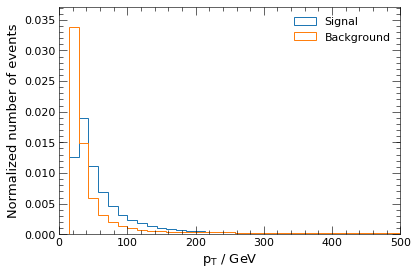

In [5]:
sig_pt = sig_jet[:idx, "TauJets.pt"]
bkg_pt = bkg_jet[:idx, "TauJets.pt"]

plt.hist(sig_pt / 1000.0, bins=35, range=(0, 500), histtype="step", normed=True, label="Signal")
plt.hist(bkg_pt / 1000.0, bins=35, range=(0, 500), histtype="step", normed=True, label="Background")
plt.legend()
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi))
plt.xlabel("$p_\mathrm{T}$ / GeV")
plt.ylabel("Normalized number of events")
plt.savefig(path.join(plot_prefix, "pt_no_reweight_1p.pdf"))

In [6]:
# Binning
bin_edges = np.percentile(bkg_pt, np.linspace(0.0, 100.0, 50))
bin_edges[0] = 20000.0 # 20 GeV lower limit
bin_edges[-1] = 4000000.0 # 4000 GeV upper limit
midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2.0

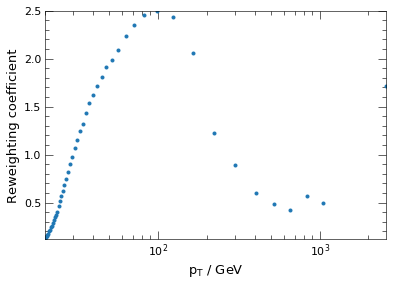

In [7]:
# Reweighting coefficient
sig_hist, _ = np.histogram(sig_pt, bins=bin_edges, density=True)
bkg_hist, _ = np.histogram(bkg_pt, bins=bin_edges, density=True)

coeff = sig_hist / bkg_hist

plt.plot(midpoints / 1000.0, coeff, ".")
plt.xlabel("$p_\mathrm{T}$ / GeV")
plt.ylabel("Reweighting coefficient")
plt.xscale("log")
plt.savefig(path.join(plot_prefix, "pt_reweight_coeff_1p.pdf"))

In [8]:
# Apply reweighting
sig_weight = np.ones_like(sig_pt)
bkg_weight = coeff[np.digitize(bkg_pt, bin_edges) - 1].astype(np.float32)

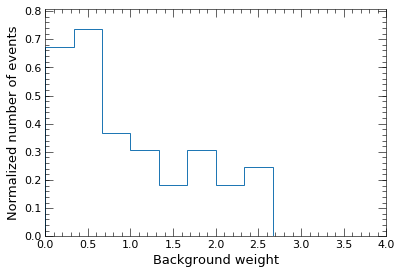

In [9]:
plt.hist(bkg_weight, bins=12, range=(0.0, 4.0), histtype="step", normed=True)
plt.xlabel("Background weight")
plt.ylabel("Normalized number of events")
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi));
plt.savefig(path.join(plot_prefix, "background_weights_1p.pdf"))

### After reweighting

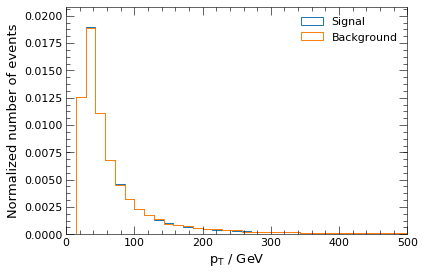

In [10]:
plt.hist(sig_pt / 1000.0, weights=sig_weight, bins=35, range=(0, 500), histtype="step", normed=True, label="Signal")
plt.hist(bkg_pt / 1000.0, weights=bkg_weight, bins=35, range=(0, 500), histtype="step", normed=True, label="Background")
plt.legend()
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi))
plt.xlabel("$p_\mathrm{T}$ / GeV")
plt.ylabel("Normalized number of events")
plt.savefig(path.join(plot_prefix, "pt_reweight_1p.pdf"))

## Create output file

### Variables from input samples

In [11]:
jet_vars = ["TauJets.pt", "TauJets.eta", "TauJets.mu", "TauJets.nVtxPU"]

In [12]:
var_names = ["TauClusters.et", "TauClusters.psfrac", "TauClusters.em1frac",
             "TauClusters.em2frac", "TauClusters.em3frac", "TauClusters.dRJetSeedAxis",
             "TauClusters.EM_PROBABILITY", "TauClusters.SECOND_R", "TauClusters.SECOND_LAMBDA",
             "TauClusters.FIRST_ENG_DENS", "TauClusters.CENTER_LAMBDA", "TauClusters.ENG_FRAC_MAX"]

In [13]:
h5opt = dict(dtype=np.float32, compression="gzip", compression_opts=9, shuffle=True, fletcher32=True)

outf = h5py.File(outf_fname, "w")

outf.attrs["idx"] = idx
outf.create_dataset("label", (2 * idx,), **h5opt)
outf.create_dataset("weight", (2 * idx,), **h5opt)

# First idx values signal, rest background
outf["label"][:idx] = 1
outf["label"][idx:] = 0
outf["weight"][:idx] = sig_weight
outf["weight"][idx:] = bkg_weight

In [14]:
for var in tqdm(jet_vars):
    ds = outf.create_dataset("data/" + var, (2 * idx,), **h5opt)
    ds[:idx] = sig_jet[:idx, var]
    ds[idx:] = bkg_jet[:idx, var]

100%|██████████| 4/4 [00:25<00:00,  6.29s/it]


In [16]:
for var in tqdm(var_names):
    ds = outf.create_dataset("data/" + var, (2 * idx, n_clusters), **h5opt)
    ds[:idx] = sig_cluster[:idx, :n_clusters, var]
    ds[idx:] = bkg_cluster[:idx, :n_clusters, var]

100%|██████████| 12/12 [10:55<00:00, 38.07s/it]


## Calculated features

In [17]:
ds = outf.create_dataset("data/TauClusters.et_log", (2 * idx, n_clusters), **h5opt)
et = outf["data/TauClusters.et"][...]
mask = ~np.isnan(et)
et[mask] = np.clip(et[mask], 1, np.inf)
ds[...] = np.log10(et)

ds = outf.create_dataset("data/TauClusters.SECOND_R_log", (2 * idx, n_clusters), **h5opt)
ds[...] = np.log10(outf["data/TauClusters.SECOND_R"][...] + 0.1)

ds = outf.create_dataset("data/TauClusters.SECOND_LAMBDA_log", (2 * idx, n_clusters), **h5opt)
ds[...] = np.log10(outf["data/TauClusters.SECOND_LAMBDA_log"][...] + 0.1)

ds = outf.create_dataset("data/TauClusters.FIRST_ENG_DENS_log", (2 * idx, n_clusters), **h5opt)
ds[...] = np.log10(outf["data/TauClusters.FIRST_ENG_DENS"][...] + 1e-6)

ds = outf.create_dataset("data/TauClusters.CENTER_LAMBDA_log", (2 * idx, n_clusters), **h5opt)
ds[...] = np.log10(outf["data/TauClusters.CENTER_LAMBDA"][...] + 1e-6)

# Transformations

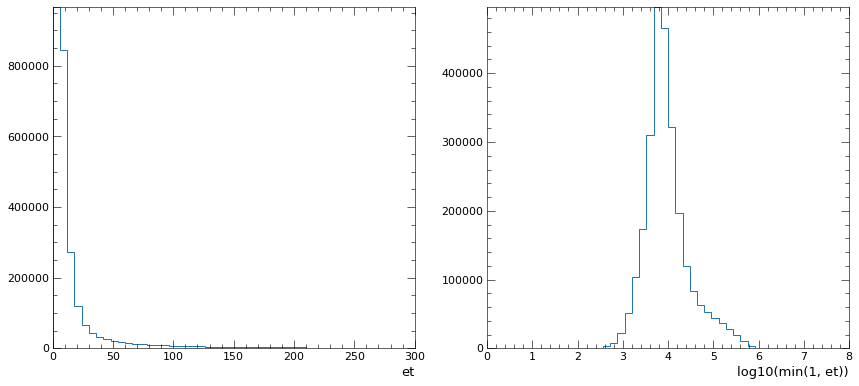

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

et = outf["data/TauClusters.et"][:, 1]
et = et[~np.isnan(et)]

ax[0].set_xlabel("et", ha="right", x=1.0)
ax[0].hist(et / 1000, bins=50, range=(0.0, 300), histtype="step")

ax[1].set_xlabel("log10(min(1, et))", ha="right", x=1.0)
ax[1].hist(np.log10(np.clip(et, 1, np.inf)), bins=50, range=(0, 8), histtype="step");

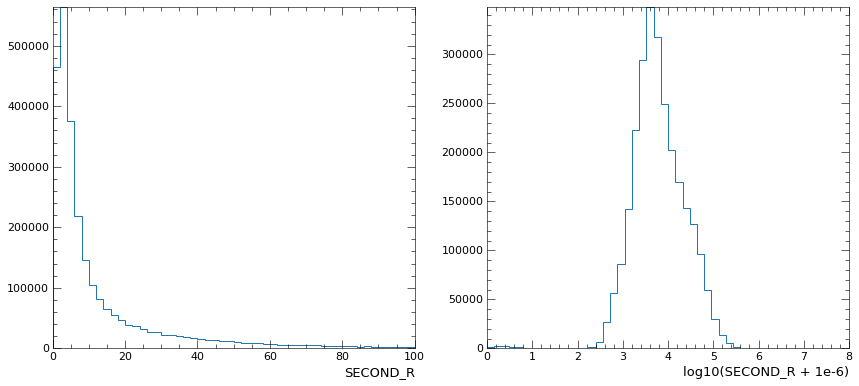

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

second_r = outf["data/TauClusters.SECOND_R"][:, 0]
second_r = second_r[~np.isnan(second_r)]

ax[0].set_xlabel("SECOND_R", ha="right", x=1.0)
ax[0].hist(second_r / 1000,
           bins=50, range=(0, 100.0), histtype="step")

ax[1].set_xlabel("log10(SECOND_R + 1e-6)", ha="right", x=1.0)
ax[1].hist(np.log10(second_r + 1e-6),
           bins=50, range=(0, 8), histtype="step");

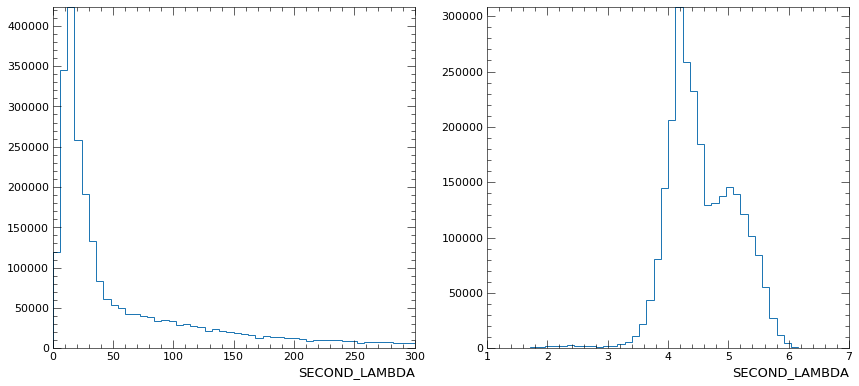

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

second_lambda = outf["data/TauClusters.SECOND_LAMBDA"][:, 0]
second_lambda = second_lambda[~np.isnan(second_lambda)]

ax[0].set_xlabel("SECOND_LAMBDA", ha="right", x=1.0)
ax[0].hist(second_lambda / 1000,
           bins=50, range=(0, 300.0), histtype="step")

ax[1].set_xlabel("SECOND_LAMBDA", ha="right", x=1.0)
ax[1].hist(np.log10(second_lambda + 1),
           bins=50, range=(1, 7), histtype="step");

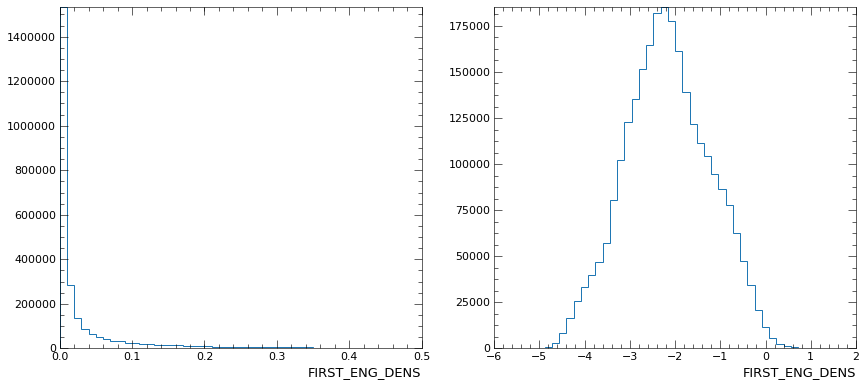

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

FIRST_ENG_DENS = outf["data/TauClusters.FIRST_ENG_DENS"][:, 0]
FIRST_ENG_DENS = FIRST_ENG_DENS[~np.isnan(FIRST_ENG_DENS)]

ax[0].set_xlabel("FIRST_ENG_DENS", ha="right", x=1.0)
ax[0].hist(FIRST_ENG_DENS,
           bins=50, range=(0, 0.5), histtype="step")

ax[1].set_xlabel("FIRST_ENG_DENS", ha="right", x=1.0)
ax[1].hist(np.log10(FIRST_ENG_DENS + 1e-6),
           bins=50, range=(-6, 2), histtype="step");

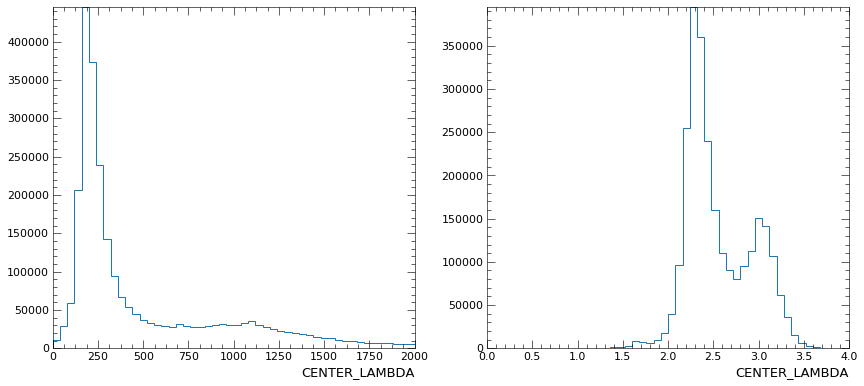

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

CENTER_LAMBDA = outf["data/TauClusters.CENTER_LAMBDA"][:, 0]
CENTER_LAMBDA = CENTER_LAMBDA[~np.isnan(CENTER_LAMBDA)]

ax[0].set_xlabel("CENTER_LAMBDA", ha="right", x=1.0)
ax[0].hist(CENTER_LAMBDA,
           bins=50, range=(0, 2000), histtype="step")

ax[1].set_xlabel("CENTER_LAMBDA", ha="right", x=1.0)
ax[1].hist(np.log10(CENTER_LAMBDA + 1e-6),
           bins=50, range=(0, 4), histtype="step");

## Monitoring plots

In [24]:
sig_mask = outf["label"][...] == 1
bkg_mask = ~sig_mask

### TauJets

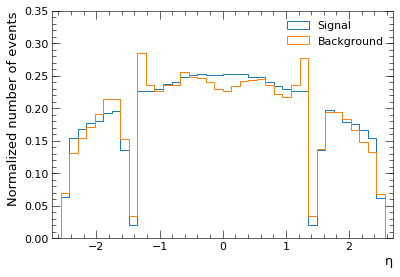

In [25]:
histopt = dict(bins=40, range=(-2.7, 2.7), normed=True, histtype="step")
plt.hist(outf["data/TauJets.eta"][sig_mask], label="Signal", **histopt)
plt.hist(outf["data/TauJets.eta"][bkg_mask], weights=bkg_weight, label="Background", **histopt)
plt.xlabel("$\eta$", ha="right", x=1.0)
plt.ylabel("Normalized number of events", ha="right", y=1.0)
plt.ylim((0.0, 0.35))
plt.legend()
plt.savefig(path.join(plot_prefix, "jet_eta_1p.pdf"))

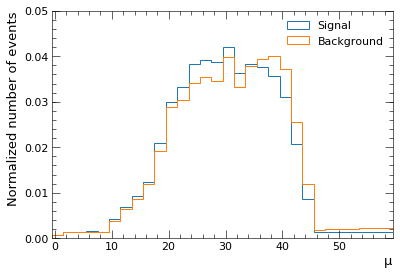

In [26]:
histopt = dict(bins=np.arange(0, 62, 2)-0.5, normed=True, histtype="step")
plt.hist(outf["data/TauJets.mu"][sig_mask], label="Signal", **histopt)
plt.hist(outf["data/TauJets.mu"][bkg_mask], weights=bkg_weight, label="Background", **histopt)
plt.xlabel("$\mu$", ha="right", x=1.0)
plt.ylabel("Normalized number of events", ha="right", y=1.0)
plt.ylim((0.0, 0.05))
plt.legend()
plt.savefig(path.join(plot_prefix, "jet_mu_1p.pdf"))

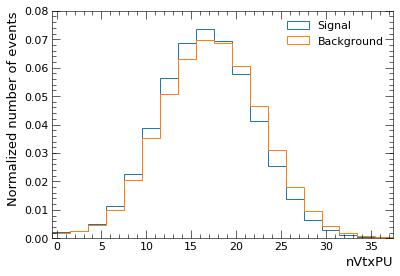

In [27]:
histopt = dict(bins=np.arange(0, 40, 2)-0.5, normed=True, histtype="step")
plt.hist(outf["data/TauJets.nVtxPU"][sig_mask], label="Signal", **histopt)
plt.hist(outf["data/TauJets.nVtxPU"][bkg_mask], weights=bkg_weight, label="Background", **histopt)
plt.xlabel("nVtxPU", ha="right", x=1.0)
plt.ylabel("Normalized number of events", ha="right", y=1.0)
plt.ylim((0.0, 0.08))
plt.legend()
plt.savefig(path.join(plot_prefix, "jet_nVtxPU_1p.pdf"))

### TauClusters

In [28]:
def cluster_plot(var, xlabel="", **histopt):
    arr = outf["data/" + var][:, :n_clusters]

    fig, ax = plt.subplots(n_clusters // 2, 2, sharex=True,
                           figsize=(12.0, 12.0 / 2.0 * (n_clusters // 2) * 3.0 / 4.0))
    ax_flat = ax.ravel()
    
    for i in range(n_clusters):
        s = arr[:, i][sig_mask]
        s = s[~np.isnan(s)]
        
        b = arr[:, i][bkg_mask]
        w = bkg_weight[~np.isnan(b)]
        b = b[~np.isnan(b)]
        
        ax_flat[i].hist(s, label="Signal", **histopt)
        ax_flat[i].hist(b, weights=w, label="Background", **histopt)
        ax_flat[i].annotate(str(i + 1) + ". in $E_\mathrm{T}$", xy=(0.05, 0.9), xycoords="axes fraction")
        
        bottom, top = ax_flat[i].get_ylim()
        ax_flat[i].set_ylim((bottom, 1.1 * top))
    
    ax[0,1].legend(loc="upper right")
    ax[n_clusters // 2 - 1, 0].set_xlabel(xlabel, ha="right", x=1.0)
    ax[n_clusters // 2 - n_clusters % 2 - 1, 1].set_xlabel(xlabel, ha="right", x=1.0)
    
    fig.subplots_adjust(hspace=0.05, wspace=0.15)
    
    return fig, ax

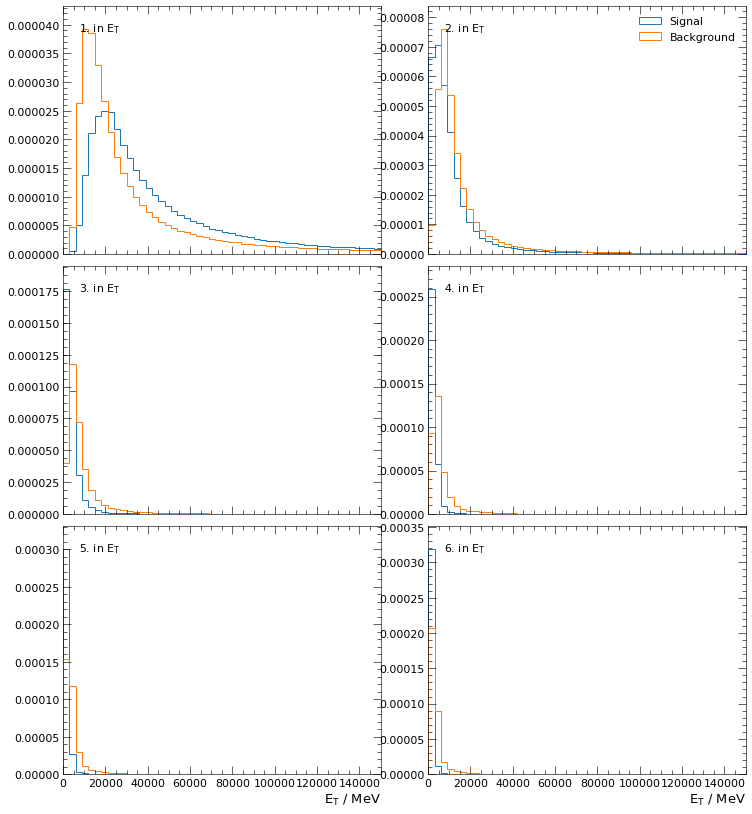

In [29]:
histopt = dict(bins=50, range=(0, 150000), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.et", xlabel="$E_\mathrm{T}$ / MeV", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_et_1p.pdf"))

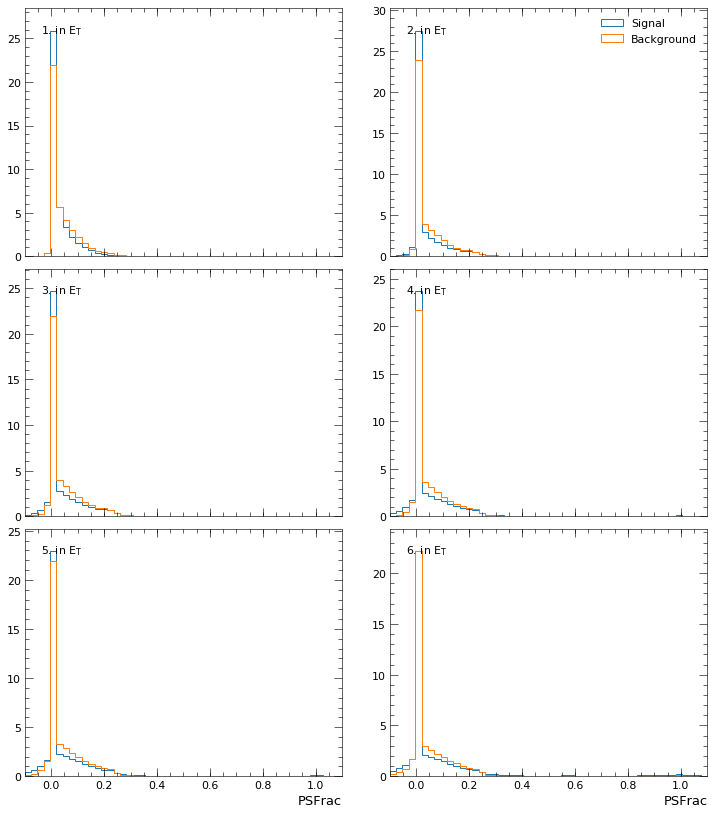

In [30]:
histopt = dict(bins=50, range=(-0.1, 1.1), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.psfrac", xlabel="PSFrac", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_psfrac_1p.pdf"))

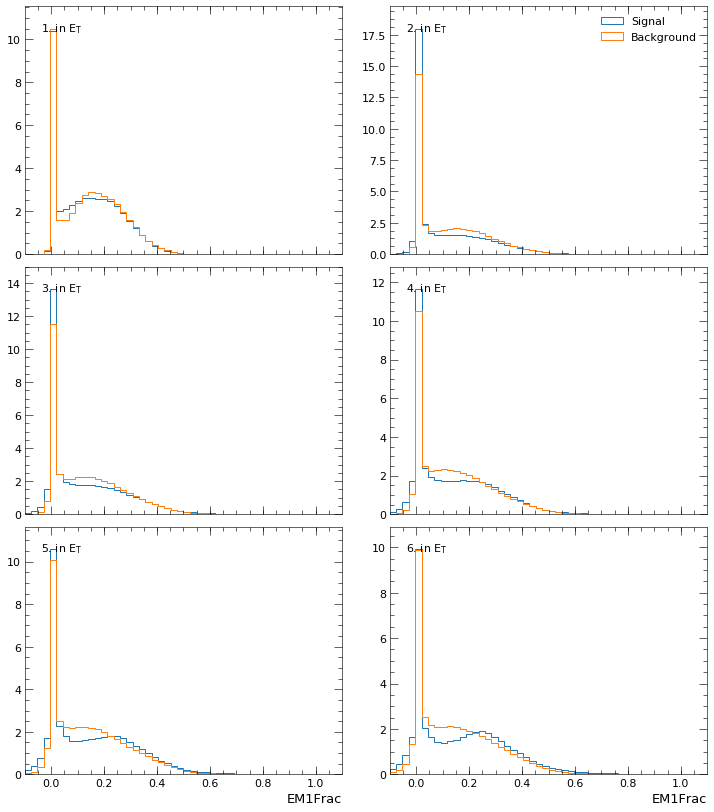

In [31]:
histopt = dict(bins=50, range=(-0.1, 1.1), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.em1frac", xlabel="EM1Frac", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_em1frac_1p.pdf"))

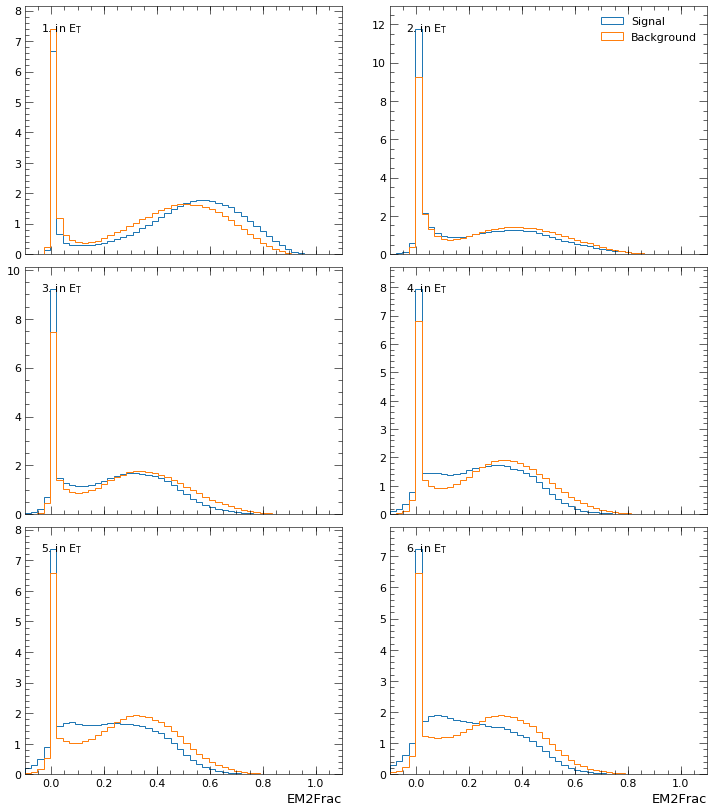

In [32]:
histopt = dict(bins=50, range=(-0.1, 1.1), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.em2frac", xlabel="EM2Frac", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_em2frac_1p.pdf"))

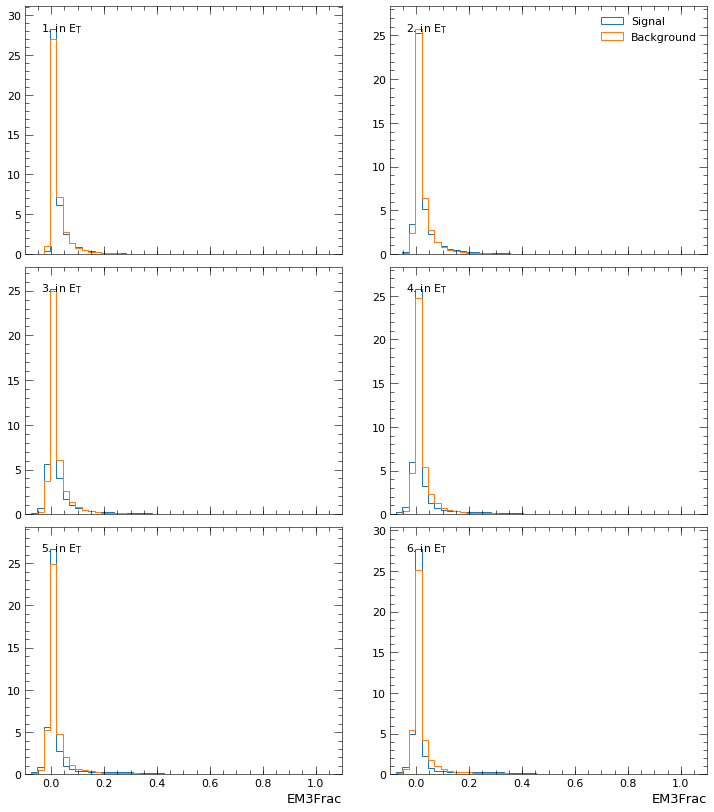

In [33]:
histopt = dict(bins=50, range=(-0.1, 1.1), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.em3frac", xlabel="EM3Frac", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_em3frac_1p.pdf"))

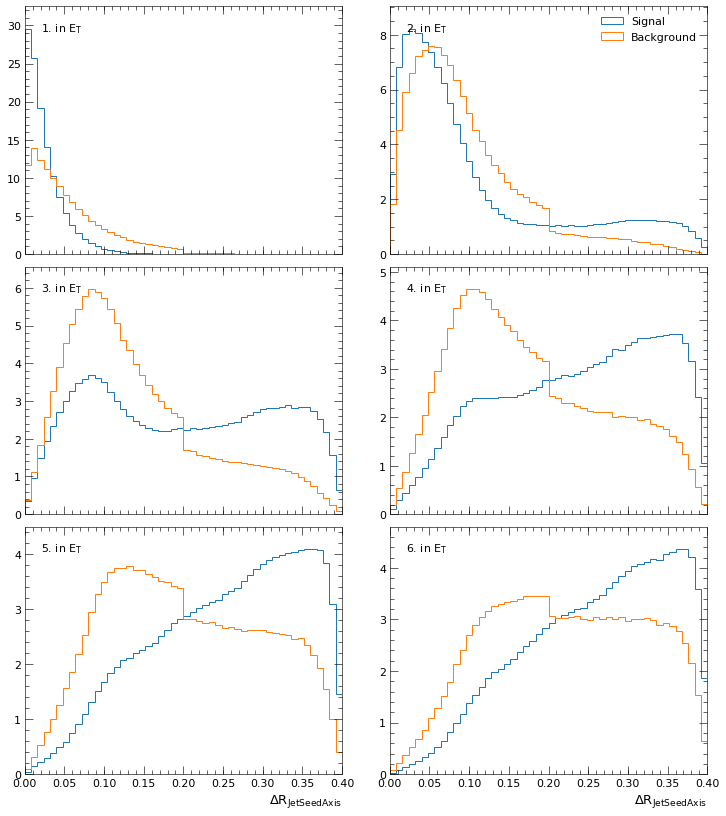

In [34]:
histopt = dict(bins=50, range=(0, 0.4), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.dRJetSeedAxis", xlabel="$\\Delta R_\\mathrm{JetSeedAxis}$", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_dRJetSeedAxis_1p.pdf"))

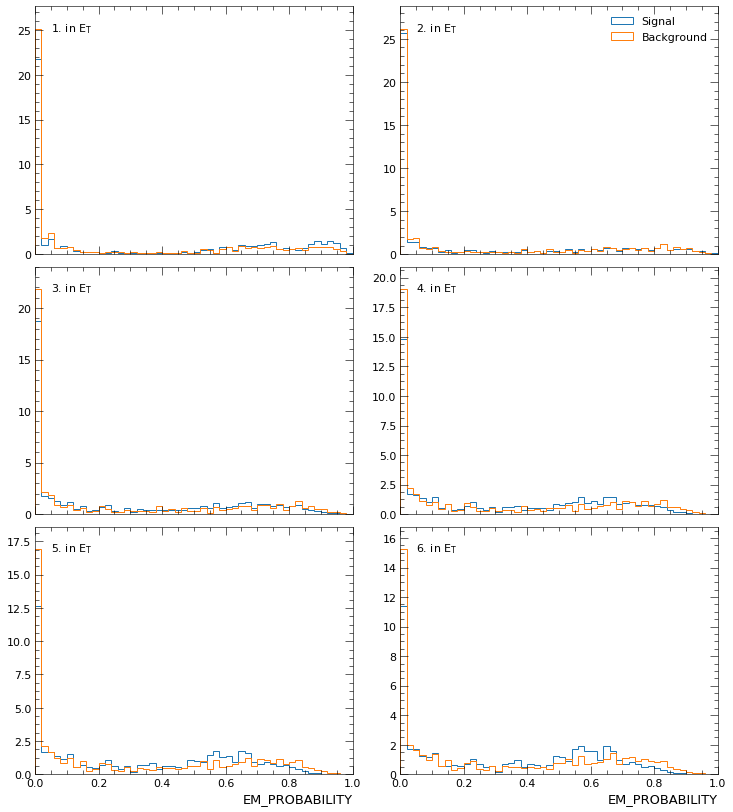

In [35]:
histopt = dict(bins=50, range=(0, 1), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.EM_PROBABILITY", xlabel="EM_PROBABILITY", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_EM_PROBABILITY_1p.pdf"))

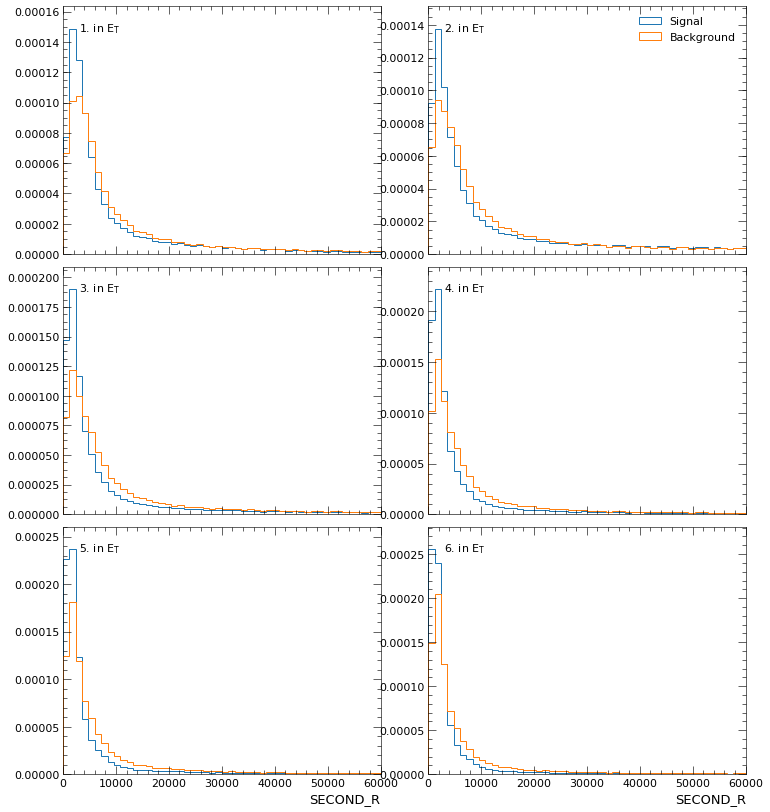

In [36]:
histopt = dict(bins=50, range=(0, 60000), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.SECOND_R", xlabel="SECOND_R", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_SECOND_R_1p.pdf"))

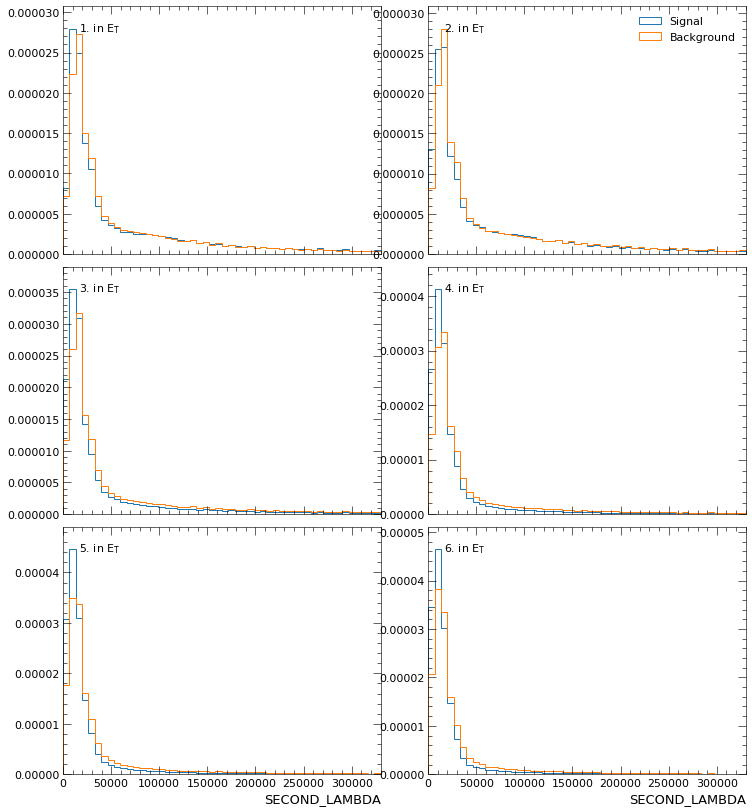

In [37]:
histopt = dict(bins=50, range=(0, 330000), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.SECOND_LAMBDA", xlabel="SECOND_LAMBDA", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_SECOND_LAMBDA_1p.pdf"))

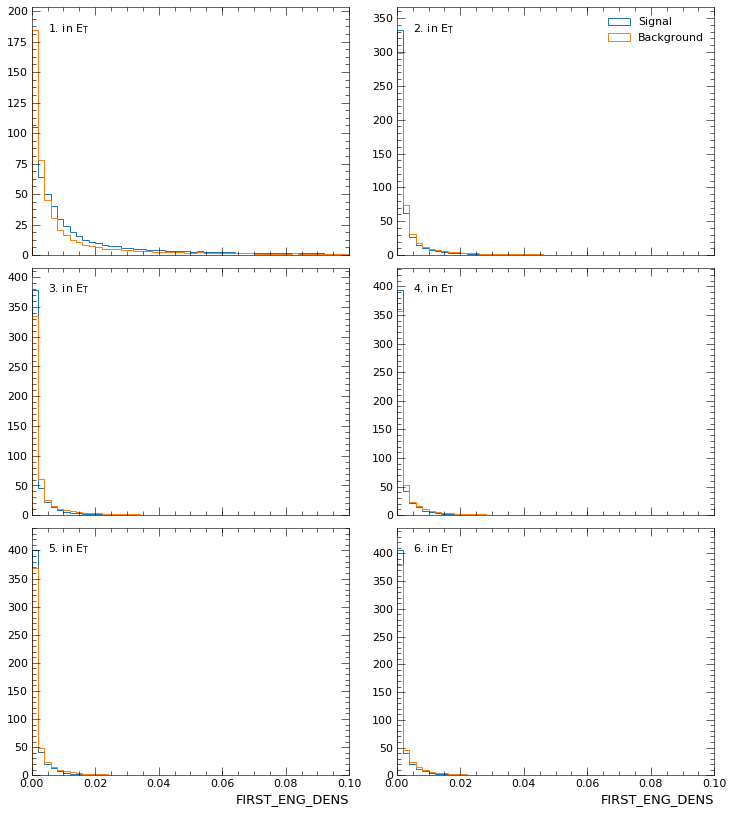

In [38]:
histopt = dict(bins=50, range=(0, 0.1), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.FIRST_ENG_DENS", xlabel="FIRST_ENG_DENS", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_FIRST_ENG_DENS_1p.pdf"))

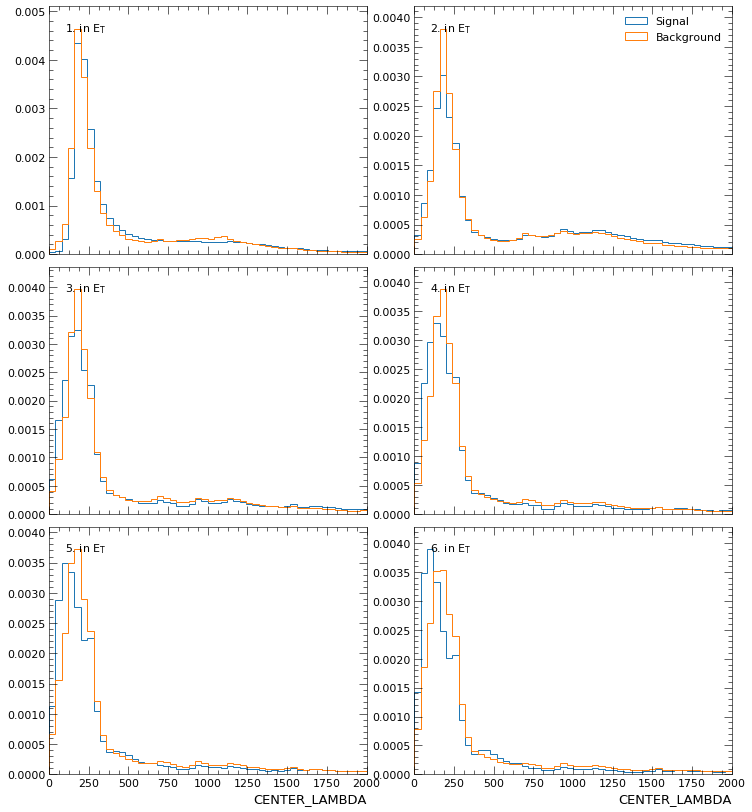

In [39]:
histopt = dict(bins=50, range=(0, 2000), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.CENTER_LAMBDA", xlabel="CENTER_LAMBDA", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_CENTER_LAMBDA_1p.pdf"))

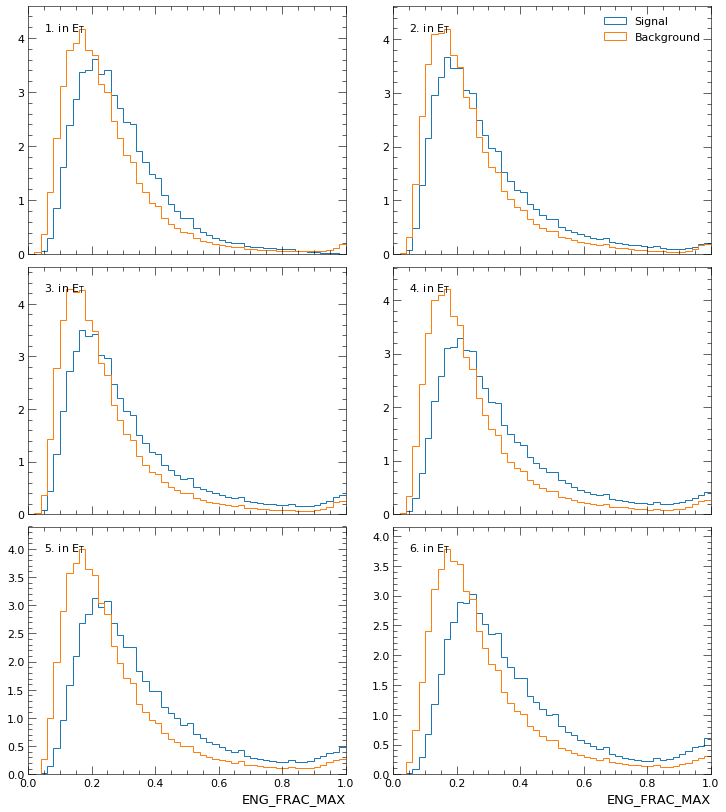

In [40]:
histopt = dict(bins=50, range=(0, 1), normed=True, histtype="step")
fig, ax = cluster_plot("TauClusters.ENG_FRAC_MAX", xlabel="ENG_FRAC_MAX", **histopt)
fig.savefig(path.join(plot_prefix, "cluster_ENG_FRAC_MAX_1p.pdf"))

## Cleanup

In [41]:
sigf_jet.close()
bkgf_jet.close()
sigf_cluster.close()
bkgf_cluster.close()
outf.close()